In [1]:
!pip install kagglehub --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: kagglehub
    Found existing installation: kagglehub 0.3.12
    Uninstalling kagglehub-0.3.12:
      Successfully uninstalled kagglehub-0.3.12


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers, models, optimizers, losses, metrics
from tensorflow.keras.callbacks import EarlyStopping
import os
import kagglehub

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Download the dataset
path = kagglehub.dataset_download("fahadullaha/facial-emotion-recognition-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'facial-emotion-recognition-dataset' dataset.
Path to dataset files: /kaggle/input/facial-emotion-recognition-dataset


In [4]:
# List files in the dataset folder
os.listdir(path)

['processed_data']

In [5]:
!apt install tree -y
!tree $path -L 2


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 1s (67.4 kB/s)
Selecting previously unselected package tree.
(Reading database ... 126281 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...
/kaggle/input/facial-emotion-recognition-dataset
└── processed_data
    ├── angry
    ├── disgust
    ├── fear
    ├── happy
    ├── neutral
    ├── sad
    └── surprise

8 directories, 0 files


In [6]:
data_dir = "/kaggle/input/facial-emotion-recognition-dataset/processed_data"

dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(96, 96),
    batch_size=32,
    color_mode="grayscale"
)

from PIL import Image

# loop over a few classes and images
for emotion in os.listdir(data_dir):
    emotion_path = os.path.join(data_dir, emotion)
    if os.path.isdir(emotion_path):
        for i, img_file in enumerate(os.listdir(emotion_path)):
            img_path = os.path.join(emotion_path, img_file)
            img = Image.open(img_path)
            print(f"{img_file} - size: {img.size} - mode: {img.mode}")
            if i >= 2:  # check first 3 images per class
                break
print("Classes: ", dataset.class_names)


Found 49779 files belonging to 7 classes.
surprise_00959.jpg - size: (96, 96) - mode: RGB
surprise_03896.jpg - size: (96, 96) - mode: RGB
surprise_00070.jpg - size: (96, 96) - mode: RGB
fear_00464.jpg - size: (96, 96) - mode: RGB
fear_aug00825.jpg - size: (96, 96) - mode: RGB
fear_02036.jpg - size: (96, 96) - mode: RGB
angry_03606.jpg - size: (96, 96) - mode: RGB
angry_03629.jpg - size: (96, 96) - mode: RGB
angry_02532.jpg - size: (96, 96) - mode: RGB
neutral_04012.jpg - size: (96, 96) - mode: RGB
neutral_01803.jpg - size: (96, 96) - mode: RGB
neutral_06921.jpg - size: (96, 96) - mode: RGB
sad_02693.jpg - size: (96, 96) - mode: RGB
sad_06062.jpg - size: (96, 96) - mode: RGB
sad_02512.jpg - size: (96, 96) - mode: RGB
disgust_aug01565.jpg - size: (96, 96) - mode: RGB
disgust_aug02948.jpg - size: (96, 96) - mode: RGB
disgust_aug00997.jpg - size: (96, 96) - mode: RGB
happy_06349.jpg - size: (96, 96) - mode: RGB
happy_05921.jpg - size: (96, 96) - mode: RGB
happy_04681.jpg - size: (96, 96) -

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(96, 96),
    batch_size=32,
    color_mode="rgb",
    label_mode="categorical"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(96, 96),
    batch_size=32,
    color_mode="rgb",
    label_mode="categorical"
)

class_names = train_ds.class_names
print("Classes:", class_names)

Found 49779 files belonging to 7 classes.
Using 39824 files for training.
Found 49779 files belonging to 7 classes.
Using 9955 files for validation.
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


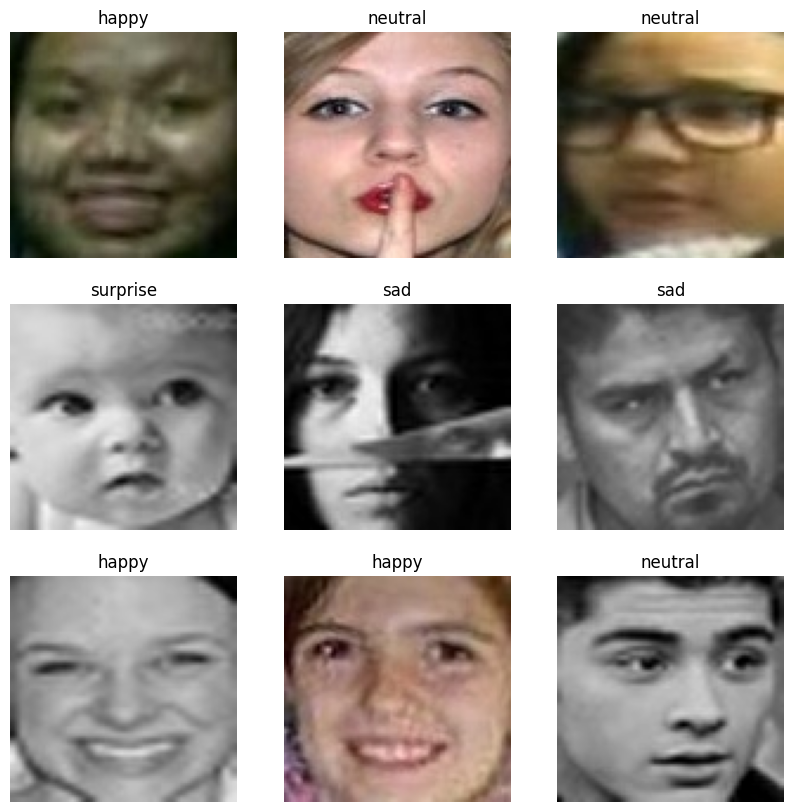

In [8]:
import matplotlib.pyplot as plt
import tensorflow as tf

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))  # RGB image
        plt.title(class_names[tf.argmax(labels[i])])
        plt.axis('off')
plt.show()


In [9]:
AUTOTUNE = tf.data.AUTOTUNE
normalization_layer = tf.keras.layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1)
])

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

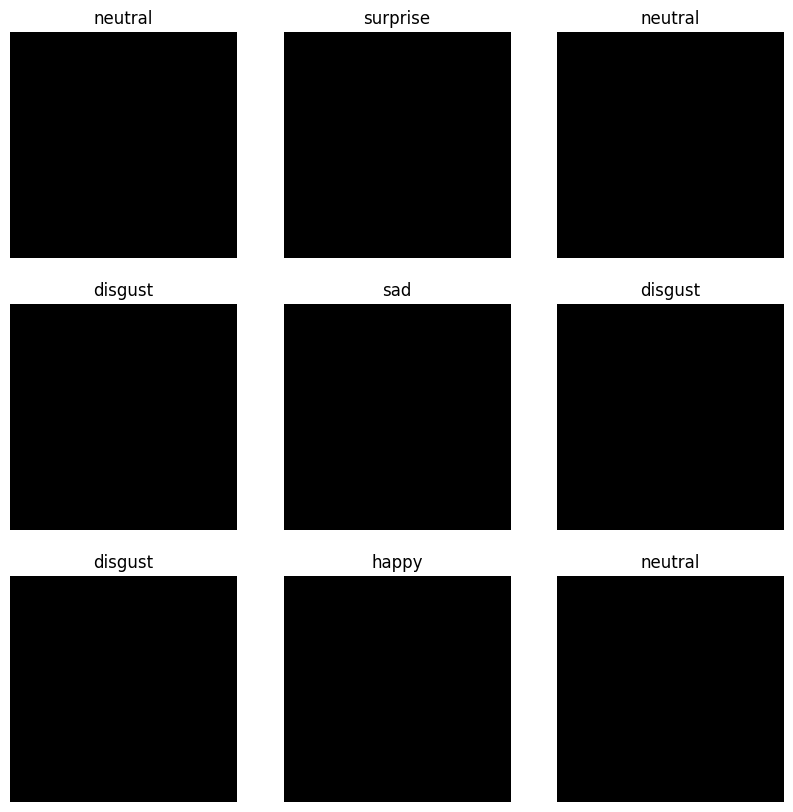

In [10]:
import matplotlib.pyplot as plt
import tensorflow as tf

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))  # RGB image
        plt.title(class_names[tf.argmax(labels[i])])
        plt.axis('off')
plt.show()


In [11]:
model = models.Sequential([
    layers.Input(shape=(96, 96, 3)),   # explicitly define input

    layers.Conv2D(16, (3,3), 1, activation='relu'),
    # layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(32, (3,3), 1,activation='relu'),
    # layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), 1,activation='relu'),
    # layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(32, (3,3), 1,activation='relu'),
    # layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(16, (3,3), 1,activation='relu'),
    # layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')  # 7 classes for emotions
])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
    # callbacks=early_stop
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 2, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 1, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,823 (206.34 KB)

 Trainable params: 52,823 (206.34 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 136s 46ms/step - accuracy: 0.2240 - loss: 1.8761 - val_accuracy: 0.2689 - val_loss: 1.7879
Epoch 2/20
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.2878 - loss: 1.7602 - val_accuracy: 0.3553 - val_loss: 1.6531
Epoch 3/20
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.3723 - loss: 1.6128 - val_accuracy: 0.4217 - val_loss: 1.5230
Epoch 4/20
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.4313 - loss: 1.4816 - val_accuracy: 0.4788 - val_loss: 1.3721
Epoch 5/20
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.4706 - loss: 1.3876 - val_accuracy: 0.5089 - val_loss: 1.2931
Epoch 6/20
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5012 - loss: 1.3122 - val_accuracy: 0.5068 - val_loss: 1.2871
Epoch 7/20
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5167 - loss: 1.2633 - val_accuracy: 0.5088 - val_loss: 1.2764
Epoch 8/20
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5250 - loss: 1.2399

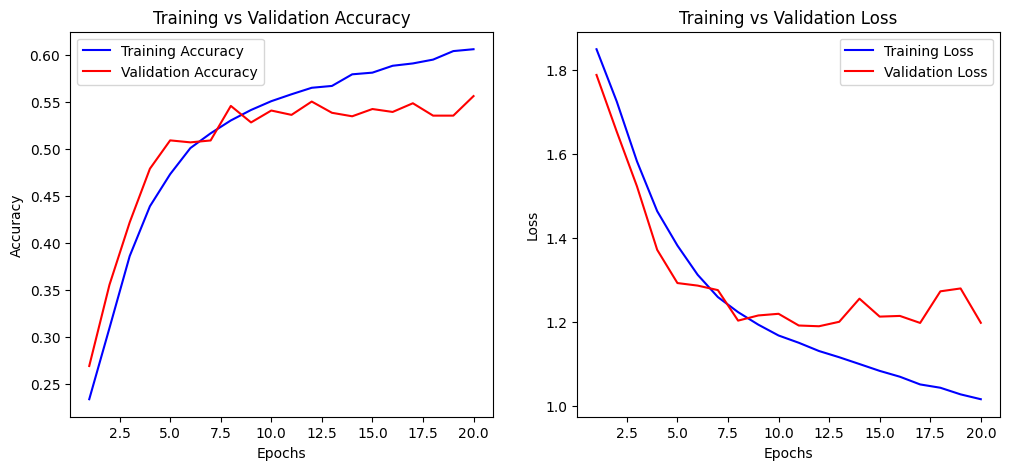

In [13]:
import matplotlib.pyplot as plt

# Extract metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)

# Plot Accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [16]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

# Loop through test dataset
for batch in val_ds.as_numpy_iterator():  # or val_ds if testing on validation set
    X, y = batch
    yhat = model.predict(X, verbose=0)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

# Print results
print(f'Precision: {pre.result().numpy():.4f}')
print(f'Recall: {re.result().numpy():.4f}')
print(f'Accuracy: {acc.result().numpy():.4f}')

Precision: 0.6972
Recall: 0.4052
Accuracy: 0.5560


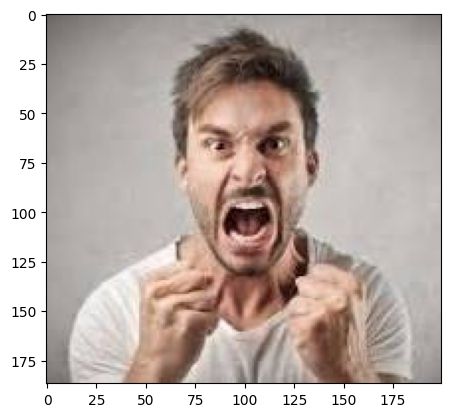

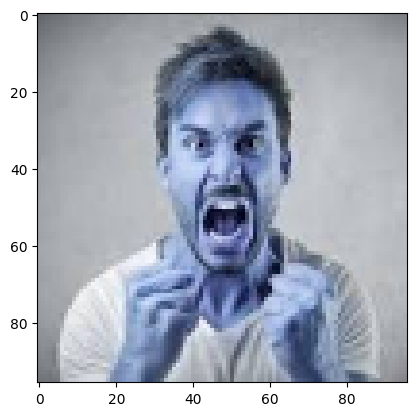

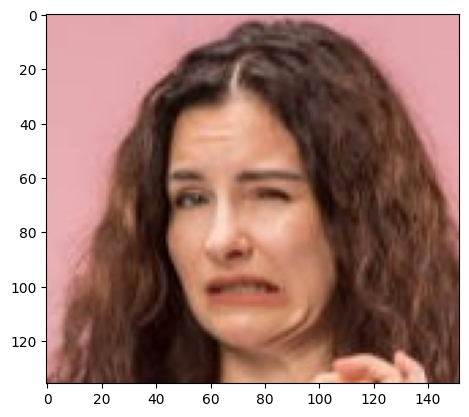

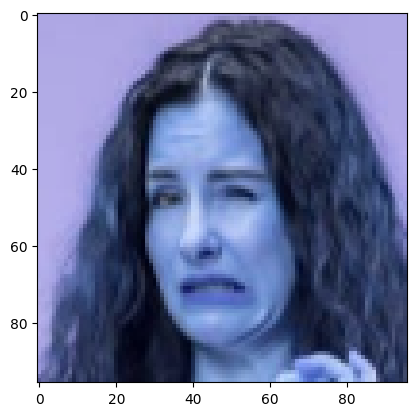

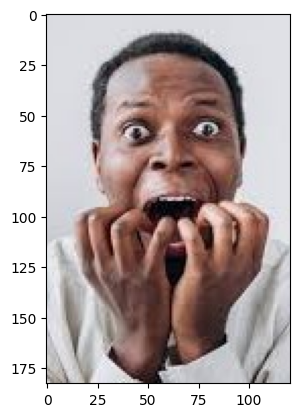

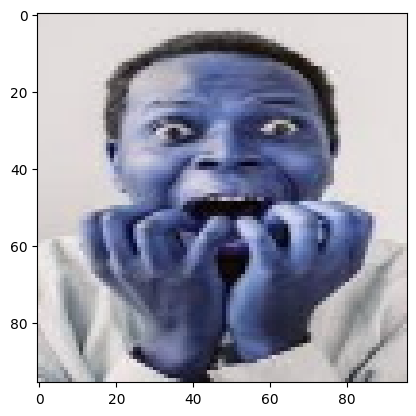

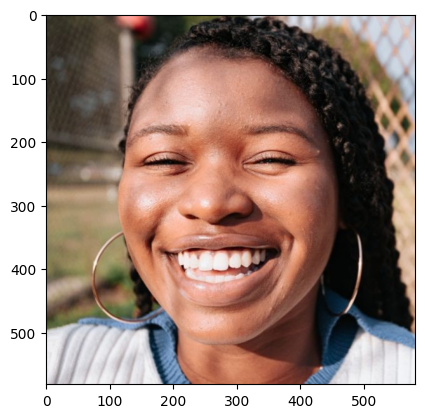

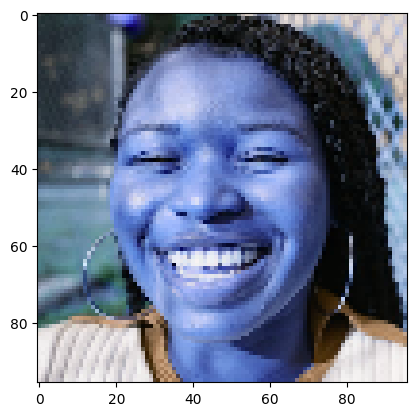

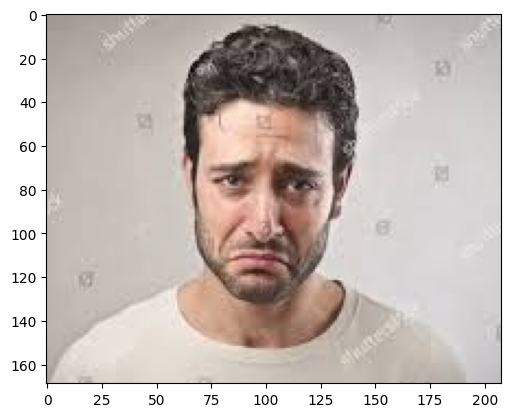

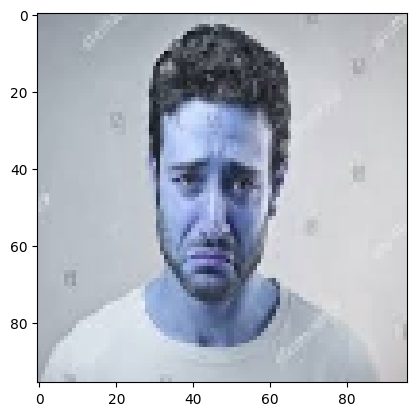

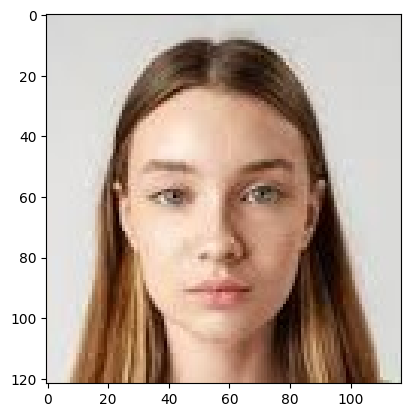

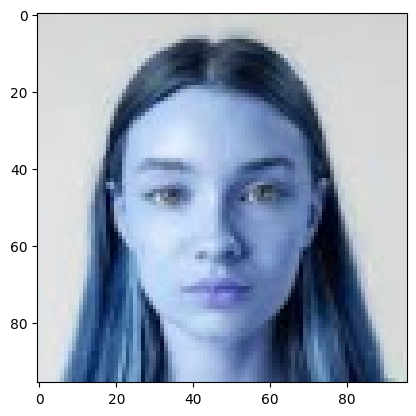

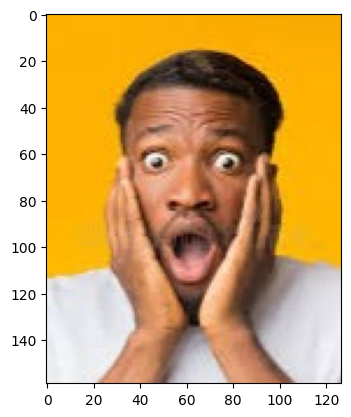

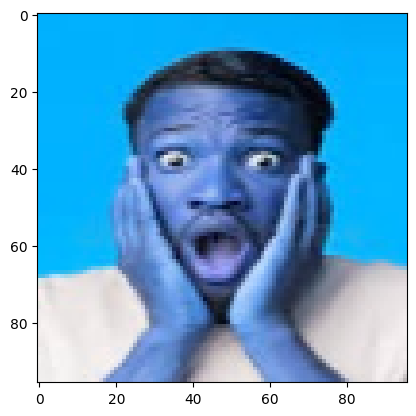

In [20]:
import cv2
import os
from google.colab.patches import cv2_imshow

image_files = [
    "angrytest.jpg", "disgusttest.jpg", "fearfultest.jpg",
    "happytest.jpg", "sadtest.jpg", "neutraltest.jpg", "surprisetest.jpg"
]

for img_name in image_files:
    img = cv2.imread(img_name)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

    resize = tf.image.resize(img, (96,96))
    plt.imshow(resize.numpy().astype(int))
    plt.show()

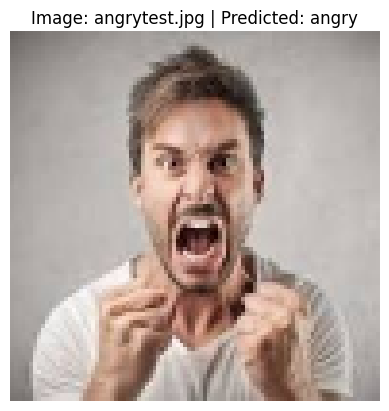

Image: angrytest.jpg
Prediction probabilities: [[0.337329   0.00885767 0.19358453 0.00102202 0.05930885 0.2444982
  0.15539975]]
Predicted class: angry
---------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
[[0.263416   0.00983888 0.23285307 0.0034552  0.09716968 0.20429967
  0.18896753]]
angry


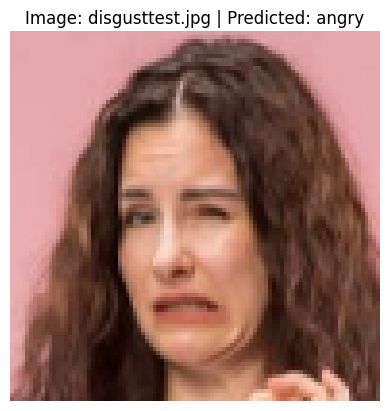

Image: disgusttest.jpg
Prediction probabilities: [[0.3087518  0.2633536  0.10433298 0.00262992 0.06455569 0.23335432
  0.02302176]]
Predicted class: angry
---------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[[0.29022244 0.40099612 0.2470374  0.00054753 0.01851138 0.02193702
  0.02074807]]
disgust


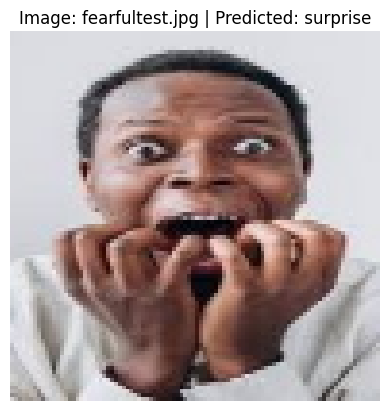

Image: fearfultest.jpg
Prediction probabilities: [[0.23575957 0.00660064 0.22202733 0.00183663 0.0494735  0.18840411
  0.29589817]]
Predicted class: surprise
---------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
[[0.38867283 0.00531246 0.23109552 0.00216615 0.03400455 0.17933886
  0.15940961]]
angry


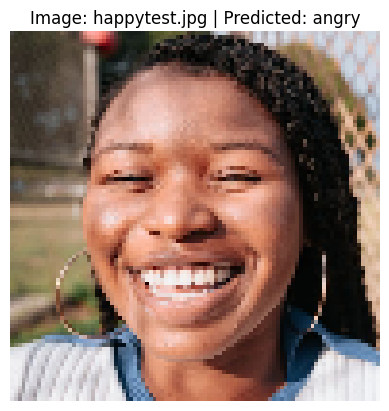

Image: happytest.jpg
Prediction probabilities: [[0.47038126 0.24007468 0.26747033 0.00062057 0.00049561 0.00231586
  0.01864181]]
Predicted class: angry
---------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
[[3.7205842e-01 2.1377017e-01 3.7710789e-01 1.7085213e-05 4.0406481e-05
  1.0489843e-04 3.6901094e-02]]
fear


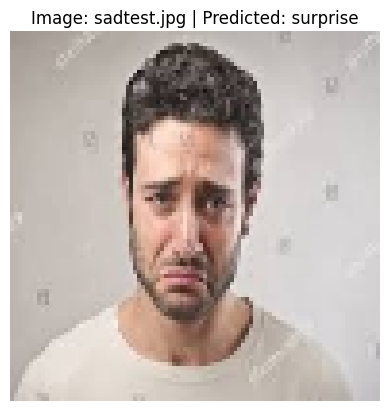

Image: sadtest.jpg
Prediction probabilities: [[3.1501181e-02 3.6201061e-04 2.5517797e-01 1.6745284e-03 7.5914174e-02
  6.0628563e-02 5.7474154e-01]]
Predicted class: surprise
---------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
[[0.11008805 0.00633634 0.21896681 0.00274908 0.24589115 0.18114904
  0.23481947]]
neutral


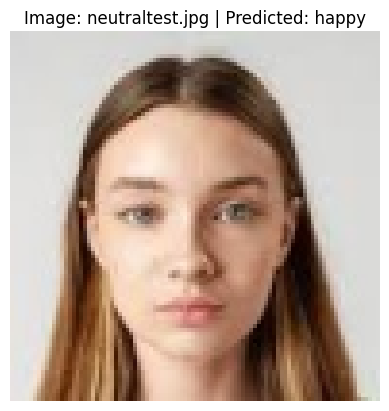

Image: neutraltest.jpg
Prediction probabilities: [[3.1742465e-02 7.1260828e-04 4.1566502e-02 8.3822089e-01 2.4144374e-02
  4.1480470e-02 2.2132693e-02]]
Predicted class: happy
---------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
[[0.09575002 0.00410182 0.14642508 0.2575395  0.18714824 0.3008417
  0.00819365]]
sad


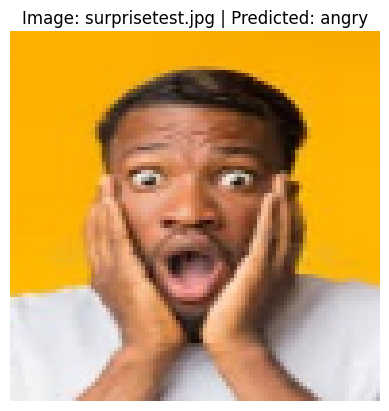

Image: surprisetest.jpg
Prediction probabilities: [[0.4447877  0.05865518 0.10268208 0.20234664 0.03512243 0.15485337
  0.00155259]]
Predicted class: angry
---------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[[0.19148898 0.00489929 0.23578689 0.01877413 0.197979   0.26899368
  0.08207801]]
sad


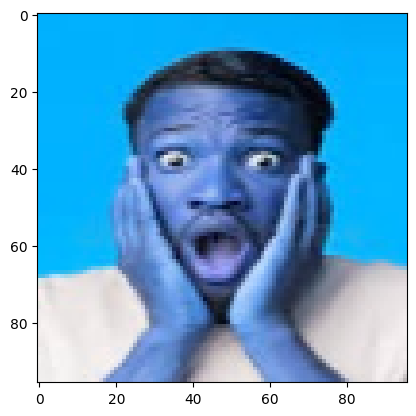

In [22]:
for img_name in image_files:
    img = cv2.imread(img_name)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
for img_name in image_files:
    img = cv2.imread(img_name)

    # Check if image exists
    if img is None:
        print(f"❌ Could not load {img_name}")
        continue

    # Convert BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize for model
    resize = tf.image.resize(img_rgb, (96, 96))

    # Prepare input for model
    img_input = np.expand_dims(resize / 255.0, axis=0)

    # Predict
    yhat = model.predict(img_input, verbose=0)
    predicted_class = class_names[np.argmax(yhat)]

    # Show image with filename + prediction
    plt.imshow(resize.numpy().astype(int))
    plt.title(f"Image: {img_name} | Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

    print(f"Image: {img_name}")
    print("Prediction probabilities:", yhat)
    print("Predicted class:", predicted_class)
    print("---------")

    resize = tf.image.resize(img, (96,96))
    plt.imshow(resize.numpy().astype(int))
    np.expand_dims(resize, 0)
    yhat = model.predict(np.expand_dims(resize/255, 0))
    print(yhat)
    print(class_names[np.argmax(yhat)])


In [24]:
from tensorflow.keras.models import load_model

model.save("facial_emotion_model.keras")
new_model = load_model("facial_emotion_model.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 16 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
